In [55]:
import numpy as np
import pandas as pd
import re
import copy
import tensorflow as tf
import keras
import re
import string
import unicodedata
from keras.models import Model,Sequential
from keras.layers import Input, Embedding, LSTM, Dense
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
hindi_sen = open("/content/IITB.en-hi.hi").read().split("\n")[:-1]
eng_sen = open("/content/IITB.en-hi.en").read().split("\n")[:-1]

In [56]:
def preprocess_sentence(sentence, remove_punctuation=False):

    sentence = sentence.lower()

    sentence = sentence.strip()

    sentence = unicodedata.normalize('NFD', sentence).encode('ascii', 'ignore').decode('utf-8')

    sentence = re.sub(' +', ' ', sentence)

    if remove_punctuation:

        sentence = sentence.translate(str.maketrans('', '', string.punctuation))

    return sentence


In [93]:
input_sentences=copy.deepcopy(eng_sen[:167998])
output_sentences=copy.deepcopy(hindi_sen[:167998])

In [94]:
input_sentences=[preprocess_sentence(x) for x in input_sentences]

In [95]:
input_tokenizer = Tokenizer(filters=" ")
output_tokenizer = Tokenizer(filters=" ")

input_tokenizer.fit_on_texts(input_sentences[:167998])
output_tokenizer.fit_on_texts(["SOS " + sent + " EOS" for sent in output_sentences[:167998]])

input_sequences = input_tokenizer.texts_to_sequences(input_sentences)
output_sequences = output_tokenizer.texts_to_sequences(["SOS " + sent + " EOS" for sent in output_sentences])
input_vocab_size = len(input_tokenizer.word_index) + 1
output_vocab_size = len(output_tokenizer.word_index) + 1



In [96]:
max_sequence_length_enc = max(len(seq) for seq in input_sequences )
max_sequence_length_dec = max(len(seq) for seq in output_sequences )
input_sequences_padded = pad_sequences(input_sequences, maxlen=max_sequence_length_enc, padding='post')
output_sequences_padded = pad_sequences(output_sequences, maxlen=max_sequence_length_dec, padding='post')
input_vocab_size = len(input_tokenizer.word_index) + 1
output_vocab_size = len(output_tokenizer.word_index) + 1
print(input_sequences_padded.shape,output_sequences_padded.shape)

(167998, 301) (167998, 215)


In [97]:
import tensorflow as tf
input_data = np.array(input_sequences_padded)
output_data = np.array(output_sequences_padded)

decoder_input = output_data[:, :-1]  # Remove the EOS token from the end
decoder_output = output_data[:, 1:]   # Remove the SOS token from the beginning

sen = tf.data.Dataset.from_tensor_slices(((input_data,decoder_input),decoder_output))
tr=sen.take(int(len(input_sentences)*0.7)).cache().shuffle(len(input_sentences)).batch(30)
val=sen.skip(int(len(input_sentences)*0.7)).take(int(len(input_sentences)*0.2)).cache().shuffle(len(input_sentences)).batch(30)
test=sen.skip(int(len(input_sentences)*0.9)).take(int(len(input_sentences)*0.1)).cache().shuffle(len(input_sentences)).batch(1)

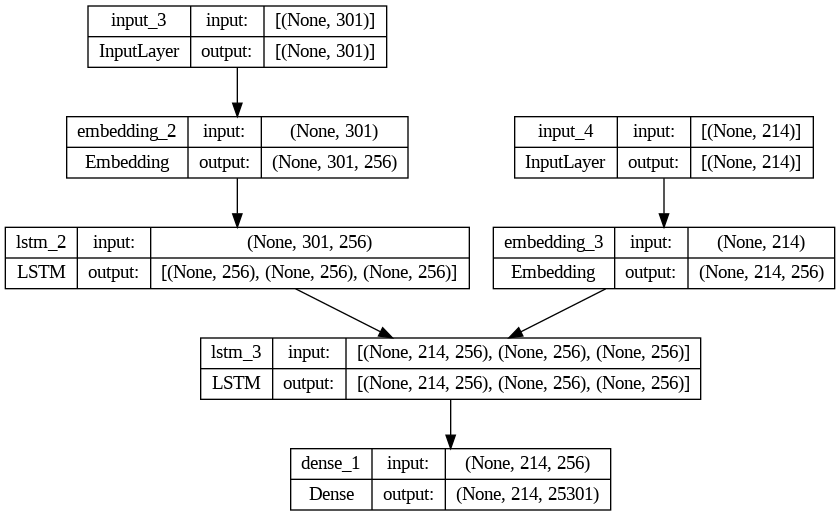

In [98]:
# Define the encoder
encoder_inputs = Input(shape=(max_sequence_length_enc,))
encoder_embedding = Embedding(input_vocab_size, 256)(encoder_inputs)
encoder_lstm, *encoder_states = LSTM(256, return_state=True)(encoder_embedding)

# Define the decoder
decoder_inputs = Input(shape=(max_sequence_length_dec-1,))
decoder_embedding = Embedding(output_vocab_size, 256)(decoder_inputs)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs,_,_ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(output_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


model = Model([encoder_inputs, decoder_inputs], decoder_outputs)



keras.utils.plot_model(model,show_shapes=True)

In [100]:
import os
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()
if os.path.isfile("/content/npmedn.h5"):
  model.load_weights("/content/npmedn.h5")
else:
  model.fit(tr, epochs=2, batch_size=30,validation_data=val)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 301)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 214)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 301, 256)     5114880     ['input_3[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, 214, 256)     6477056     ['input_4[0][0]']                
                                                                                            

In [101]:
model.save_weights('/content/npmedn.h5')

In [102]:
#deoding the sequence
reverse_word_index_hi = dict([(value, key) for (key, value) in output_tokenizer.word_index.items()])
reverse_word_index_eng = dict([(value, key) for (key, value) in input_tokenizer.word_index.items()])
print(reverse_word_index_hi[7])

नहीं


In [103]:
def decode(predicted_output_sequence):
  decoded_output = []
  for token_indices in predicted_output_sequence:
    token_index = np.argmax(token_indices)
    if token_index == 0:
        continue
    token_word = reverse_word_index_hi.get(token_index, '<unk>')
    if token_word == 'EOS':
        break
    decoded_output.append(token_word)
  return

In [105]:
for i in test:
  print(decode(i[1]))
  break